In [25]:
import os
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures

In [2]:
# Set working directory
os.chdir(os.path.dirname(os.getcwd()))
project_path = os.getcwd()
print(project_path)

C:\Users\darkg\PycharmProjects\master_thesis


In [3]:
# Load local libraries
from src.Fundus import Fundus
from src.get_info_from_name import get_info_from_name
from src.logger import set_logger as sl

In [4]:
# Load file with metadata
ukbb = pd.read_csv("./data/ukbb_metadata.csv")
ukbb.head()

,file,sex,patient_id,eye_side,visit,replica
0,1000180_21015_0_0.png,female,1000180,left,0,0
1,1000180_21016_0_0.png,female,1000180,right,0,0
2,1000303_21015_1_0.png,female,1000303,left,1,0
3,1000303_21016_1_0.png,female,1000303,right,1,0
4,1000390_21015_1_0.png,male,1000390,left,1,0


## Eye side

In [5]:
ukbb.eye_side.value_counts()

right    88156
left     86830
Name: eye_side, dtype: int64

In [6]:
ukbb.eye_side.value_counts()/ukbb.shape[0]

right    0.503789
left     0.496211
Name: eye_side, dtype: float64

## Female/Male distribution

### CFP

In [7]:
ukbb.sex.value_counts()

female    93753
male      81233
Name: sex, dtype: int64

In [8]:
ukbb.sex.value_counts()/ukbb.shape[0]

female    0.535774
male      0.464226
Name: sex, dtype: float64

### Patients

In [9]:
# Number of unique patients
ukbb.patient_id.unique().shape[0]

85623

In [10]:
# Number of patients per sex
for by, df in ukbb.groupby("sex"):
    print(by, df.patient_id.unique().shape[0], df.patient_id.unique().shape[0]/ukbb.patient_id.unique().shape[0], sep="\t")

female	45948	0.5366315125608774
male	39675	0.4633684874391227


## Images

In [11]:
data_path = os.path.abspath(f"A:raw_300x300/")

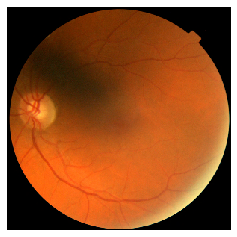

In [14]:
example = os.path.join(data_path, os.listdir(data_path)[0])

# Read image
eye = Fundus(example)

# Show image
eye.show()

In [15]:
# Dimensions 
eye.dim

(300, 300)

### Get RGB **mean** values for each image

In [16]:
%%time
if not os.path.isfile(os.path.abspath("./data/ukbb_rgb_means.csv")):
    # Get mean RGB values as well as RGB standard deviation
    def parallel_rgb_mean(f):
        path = os.path.join(data_path, f)
        eye = Fundus(path)
        return path, eye.get_rgb_mean() 

    with concurrent.futures.ThreadPoolExecutor() as  executor:
        results = executor.map(parallel_rgb_mean, ukbb.file)

    # Get the results
    results = [[os.path.basename(p), m[0], m[1], m[2]] for p, m in results]

    # Save results
    means = pd.DataFrame(results, columns=["file","r","g","b"])
    means.to_csv("./data/ukbb_rgb_means.csv", index=False)
else:
    # Load mean values
    means = pd.read_csv(os.path.abspath("./data/ukbb_rgb_means.csv"))

Wall time: 6min 39s


### Get RGB **standar deviation** values for each image

In [21]:
%%time
if not os.path.isfile(os.path.abspath("./data/ukbb_rgb_std.csv")):
    # Get mean RGB values as well as RGB standard deviation
    def parallel_rgb_std(f):
        path = os.path.join(data_path, f)
        eye = Fundus(path)
        return path, eye.get_rgb_std() 

    with concurrent.futures.ThreadPoolExecutor() as  executor:
        results = executor.map(parallel_rgb_std, ukbb.file)

    # Get the results
    results = [[os.path.basename(p), s[0], s[1], s[2]] for p, s in results]

    # Save results
    std = pd.DataFrame(results, columns=["file","r","g","b"])
    std.to_csv("./data/ukbb_rgb_std.csv", index=False)
else:
    # Load std values
    std = pd.read_csv(os.path.abspath("./data/ukbb_rgb_std.csv"))

Wall time: 7min 21s


In [22]:
std

,file,r,g,b
0,1000180_21015_0_0.png,21.730475,45.968781,89.803979
1,1000180_21016_0_0.png,15.548260,40.903174,81.531730
2,1000303_21015_1_0.png,11.619944,19.072421,30.874045
3,1000303_21016_1_0.png,2.848438,10.702676,24.873549
4,1000390_21015_1_0.png,15.526307,61.533357,109.975483
...,...,...,...,...
174981,6025089_21016_0_0.png,12.131803,47.802913,106.459436
174982,6025245_21016_0_0.png,11.546777,27.239413,54.992586
174983,6025315_21016_0_0.png,34.993228,63.997688,108.825957
174984,6025327_21016_1_0.png,9.144564,25.774594,56.621171
